In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def SaveDataToDF(f):
    myData = []
    myDataNames = []
    def saveDat(item):
        if 'Data' in str(f[item].id):
            data2use = f[item][()]
            if data2use.ndim == 2:#some groups have multiple columns and this messes up the translation to a df at the end of this function
                [a,b] = data2use.shape
                for col in np.arange(0,b):
                    myData.append(data2use[:,col])
                    dataName = (f[item].name).split('/')[-1] + str(col)
                    myDataNames.append(dataName)
            else:
                myData.append(f[item][()])
                dataName = (f[item].name).split('/')[-1]
                myDataNames.append(dataName)
        
    f.visit(saveDat)
    allData = pd.DataFrame(myData).T
    allData.columns = myDataNames
    f.close()
    return allData
archived_path = '/home/group/CA1Results/all_data_001'

# Single Cell Model Voltage

In [2]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
import h5py
#do not rerun
h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc', 'class_pvbasketcell.hoc', 'class_olmcell.hoc']
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()
callNames

['h.axoaxoniccell()', 'h.olmcell()', 'h.pvbasketcell()', 'h.pyramidalcell()']

In [3]:
test = h.axoaxoniccell()

In [4]:
h.psection(test)

axoaxoniccell[0].soma[0] { nseg=1  L=20  Ra=100
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=10}
	insert capacitance { cm=1.4}
	insert ch_KvA { gmax_ch_KvA=0.00015}
	insert ch_CavN { gmax_ch_CavN=0.0008}
	insert ch_CavL { gmax_ch_CavL=0.005}
	insert ch_KCaS { gmax_ch_KCaS=2e-06}
	insert ch_KvCaB { gmax_ch_KvCaB=2e-07}
	insert ca_ion { cai=5e-05 cao=2}
	insert ch_Nav { gmax_ch_Nav=0.15}
	insert na_ion { ena=55}
	insert ch_Kdrfast { gmax_ch_Kdrfast=0.013}
	insert k_ion { ek=-90}
	insert ch_leak { g_ch_leak=0 gmax_ch_leak=0.000180018 e_ch_leak=-65}
}


1.0

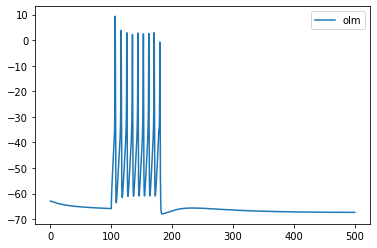

In [5]:
tstop = 500
iclamp_amp = 0.6

Cell1 = h.olmcell()

iclamp = h.IClamp(Cell1.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 78
iclamp.amp =iclamp_amp


vCell1 = h.Vector().record(Cell1.soma[0](0.5)._ref_v)


h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(tstop)

vCell1 = np.array(vCell1)


time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
plt.plot(time,vCell1,label=str(Cell1).split('cell')[0])
plt.legend()
plt.show()

# Raster

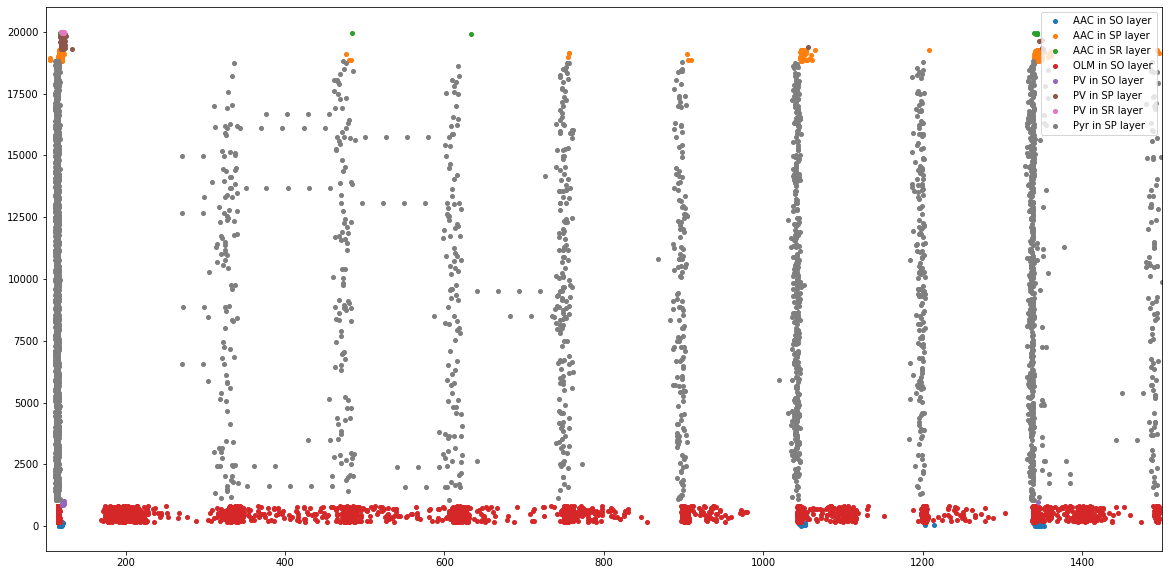

In [6]:
f = h5py.File(os.path.join(archived_path,'network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
f = h5py.File(os.path.join(archived_path,'output','spikes.h5'), 'r')
spikesDF = SaveDataToDF(f) 


cellLocations = pd.read_csv('cell_locations.csv')#this was for the old build, i'm just reading it instead of writing the list coz lazy
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear

nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})



namesList = []
for i in range(len(spikesDF['node_ids'])):
    namesList.append(nodesDF['node_type_id'][spikesDF['node_ids'][i]])
spikesDFM = pd.concat([spikesDF,pd.Series(namesList)],axis=1)
spikesDFM.columns = ['node_ids','timestamps','node_type_id']

plt.figure(figsize=(20,10))
groups = spikesDFM.groupby('node_type_id')
for name, group in groups:
    plt.plot(group.timestamps, group.node_ids,marker='o',linestyle="",markersize=4, label=name)
plt.legend(loc='upper right')
plt.xlim([100,1500])
#plt.hlines(counts,xmin=0, xmax = max(spikesDFM['timestamps']))
#plt.savefig('raster.png',dpi=400)
plt.show()

In [7]:
spikesDFM.to_csv('spikesDFM.csv')

# voltages of cells in network by ID

In [8]:
f = h5py.File(os.path.join(archived_path,"output",'v_report.h5'), 'r')
#f.visit(print)
node_ids = f['report/biophysical/mapping/node_ids'][()]
voltages = f['report/biophysical/data'][()]
time = f['report/biophysical/mapping/time'][()]
f.close()
timesteps = np.arange(time[0],time[1],float(time[2]))

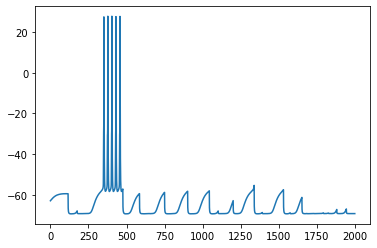

In [9]:
ID = 13666
start,end = 0,20000
plt.plot(timesteps[start:end],voltages[start:end,np.where(node_ids == ID)[0][0]])
plt.savefig('voltage.png',dpi=300)
plt.show()

# ecp

In [10]:
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

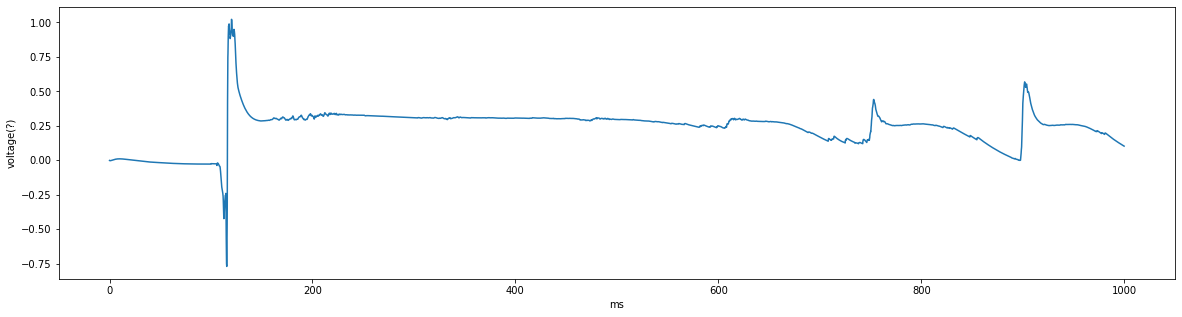

In [11]:
start,end = 0, 10000
plt.figure(figsize=(20,5))
plt.plot(np.arange(time[0],time[1],time[2])[start:end],data[start:end,10])
#plt.xlim([175,200])
plt.xlabel('ms')
#plt.ylim([0,0.1])
plt.ylabel('voltage(?)')
#plt.savefig('ecp.png',dpi=400)
plt.show()

In [12]:
from scipy import signal
from scipy.signal import hilbert
import numpy as np

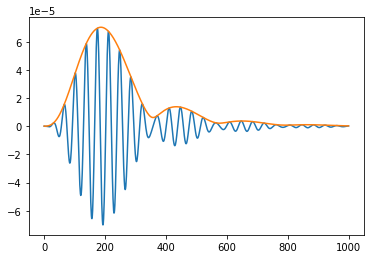

In [13]:
start,end = 0, 100000
sos = signal.butter(4, [250,300], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])
plt.plot(filtered[:1000])
analytical_signal = hilbert(filtered[:1000])
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope)
plt.show()

In [14]:
data.shape

(100000, 13)

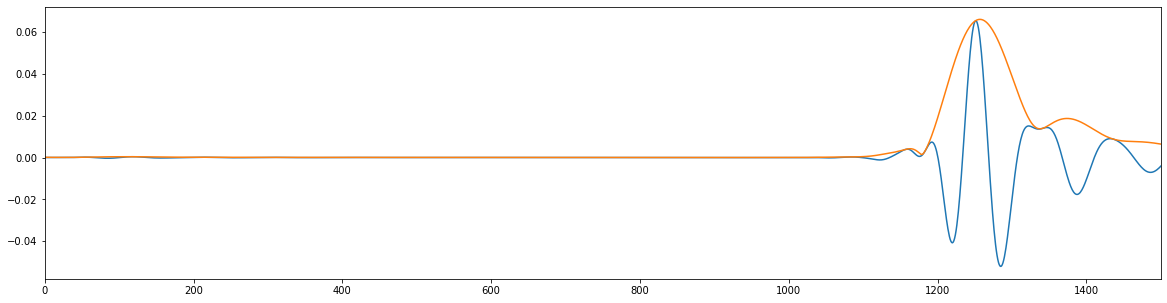

In [15]:
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

start,end = 0, 10000
Fs = 10000
sos = signal.butter(4, [int(10/(1000/Fs)),int(20/(1000/Fs))], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])

plt.figure(figsize=(20,5))
plt.plot(filtered)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope)

plt.xlim([0,1500])
#plt.hlines(counts,xmin=0, xmax = max(spikesDFM['timestamps']))
#plt.savefig('raster.png',dpi=400)
plt.show()


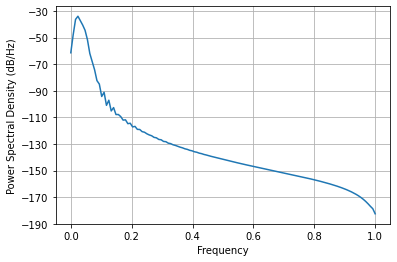

In [16]:
plt.psd(filtered)
plt.show()

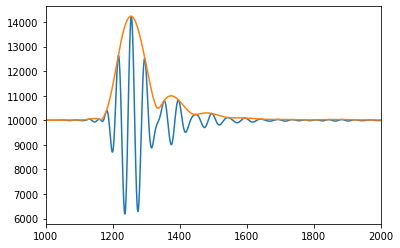

In [17]:
from scipy import signal
from scipy.signal import hilbert
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')


nids = f['spikes']['biophysical']['node_ids'][:]
ts =f['spikes']['biophysical']['timestamps'][:]
f.close()

#plt.plot(ts,nids,'.',color='k',alpha=0.4)


f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

# start,end = 0, 10000
# Fs = 10000
# b,a = signal.butter(4, [int(120/(1000/Fs)),int(220/(1000/Fs))], btype='bandpass', fs=Fs, analog=False)

# filtered = signal.filtfilt(b, a, data[start:end,0])
start,end = 0, 10000
sos = signal.butter(4, [200,300], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])
#plt.plot(data[start:end,-1])
#plt.twinx()
plt.plot(filtered*100000+10000)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope*100000+10000)
plt.xlim(1000,2000)
plt.show()

In [18]:
archived_path = '/home/group/CA1Results/all_data_001'

f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')
f.visit(print)

spikes
spikes/biophysical
spikes/biophysical/node_ids
spikes/biophysical/timestamps


In [19]:
from scipy import signal
from scipy.signal import hilbert

archived_path = '/home/group/CA1Results/all_data_002'

f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')
nids = f['spikes']['biophysical']['node_ids'][()]
ts =f['spikes']['biophysical']['timestamps'][()]
f.close()

f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()
times = np.arange(time[0],time[1],time[2])[start:end]
plt.plot(ts,nids,'.',color='k',alpha=0.4)

start,end = 0, 10000
Fs = 10000
b,a = signal.butter(4, [int(120/(1000/Fs)),int(220/(1000/Fs))], btype='bandpass', fs=Fs, analog=False)

filtered = signal.filtfilt(b, a, data[start:end,0])

#plt.plot(data[start:end,-1])
plt.twinx()
plt.plot(times,filtered)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(times,amplitude_envelope)
#plt.xlim(0,200)
plt.show()

OSError: Unable to open file (Unable to open file: name = '/home/group/ca1results/all_data_002/output/spikes.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
int(220/(1000/Fs))

# orientation

In [ ]:
callNames

In [ ]:
Cell1 =h.olmcell()


In [ ]:
cell_data = pd.DataFrame()
#cell_data.columns = ['cell_type','X','Y','Z','cell_part']

In [ ]:
xs,ys,zs,cell_names,cell_parts = [],[],[],[],[]
for sec in h.allsec(Cell1):
    num_secs = sec.n3d()
    for i in range(num_secs):
        print(sec)
        cell_names.append(str(sec).split('[')[0])
        cell_parts.append(str(sec).split('.')[1])
        xs.append(sec.x3d(i))
        ys.append(sec.y3d(i))
        zs.append(sec.z3d(i))




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(cell_data['X'], cell_data['Y'], cell_data['Z'])
ax.set_xlabel('X_Axis')
ax.set_ylabel('Y_Axis')
ax.set_zlabel('Z_Axis')
ax.view_init(elev=20, azim=30)
plt.savefig('pyramidal_geom.png')

# automated plotting

In [ ]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
import h5py
#do not rerun
h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc', 'class_pvbasketcell.hoc', 'class_olmcell.hoc']
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()
callNames

In [ ]:
def plot_dend(dendrite,color):
    r,c = dendrite.shape
    start,end = dendrite.iloc[0],dendrite.iloc[r-1]
    X = [start['X'],end['X']]
    Y = [start['Y'],end['Y']]
    Z = [start['Z'],end['Z']]
        
    ax.plot(X,Y,Z,lw = 5,color=color)


In [ ]:
def plot_soma(cell_data):
    soma = cell_data[cell_data['cell_part'].str.contains('soma')]
    color = color_dict[cell_data['cell_type'].iloc[0]]
    originX,originY,originZ = soma['X'].iloc[0],soma['Y'].iloc[0],soma['Z'].iloc[0]
    ax.scatter(originX,originY,originZ,s=100,color=color)

In [ ]:
def cell_to_df(Cell1):
    xs,ys,zs,cell_names,cell_parts = [],[],[],[],[]
    cell_data = pd.DataFrame()
    for sec in h.allsec(Cell1):
        num_secs = sec.n3d()
        for i in range(num_secs):
            cell_names.append(str(sec).split('[')[0])
            cell_parts.append(str(sec).split('.')[1])
            xs.append(sec.x3d(i))
            ys.append(sec.y3d(i))
            zs.append(sec.z3d(i))


    cell_data['cell_type'] = cell_names
    cell_data['cell_part'] = cell_parts
    cell_data['X'] = xs
    cell_data['Y'] = ys
    cell_data['Z'] = zs
    
    return cell_data

In [ ]:
def plot_parts(cell_data,cell_branch):

    color = color_dict[cell_data['cell_type'].iloc[0]]
    if np.sum(cell_data['cell_part'].str.contains(cell_branch)) == 0:
        return
    
    dend_num = int(str(cell_data[cell_data['cell_part'].str.contains(cell_branch)]['cell_part'][-1:].iloc[0]).split('[')[1].split(']')[0])

    
    for i in range(dend_num):
        dendrite = cell_data[cell_data['cell_part'].str.contains(cell_branch)]
        dendrite = dendrite[dendrite['cell_part'] == f"{cell_branch}[{i}]"]

        plot_dend(dendrite,color)

    plot_soma(cell_data)    
    ax.set_xlabel('X_Axis')
    ax.set_ylabel('Y_Axis')
    ax.set_zlabel('Z_Axis')
    ax.view_init(elev=20, azim=30)


In [ ]:
def plot_wrapper(cell_data):
    plot_parts(cell_data,'basal')
    plot_parts(cell_data,'apical')
    plot_parts(cell_data,'dend')
    plot_parts(cell_data,'axon')
    

In [ ]:

#cell_dict = {'gid':1,'data' :cell_data}
color_dict = {'pvbasketcell':'blue',
             'axoaxoniccell': 'green',
             'olmcell': 'orange',
             'pyramidalcell': 'red'}

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Cell1 =h.pvbasketcell()
cell_data = cell_to_df(Cell1)
plot_wrapper(cell_data)


Cell1 =h.pyramidalcell()
cell_data = cell_to_df(Cell1)
plot_wrapper(cell_data)

In [ ]:
Cell1

In [ ]:
with open('cell_positions.csv') as f:
    data = f.readlines()
f.close()

In [ ]:
orens = pd.read_csv('cell_positions.csv',sep=',')

In [ ]:
f = h5py.File(os.path.join("network",'biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
cellLocations = pd.read_csv('cell_locations.csv')
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear
nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})

In [ ]:
nodesDF[nodesDF['node_type_id'].str.contains('AAC')]['node_id'].iloc[0]

In [ ]:
nodesDF[nodesDF['node_type_id'].str.contains('Pyr')]['node_id'].iloc[0]

In [ ]:
nodesDF[nodesDF['node_type_id'].str.contains('OLM')]['node_id'].iloc[0]

In [ ]:
with open("cell_positions.json", "r") as file:
    loaded_dict = json.load(file)

In [ ]:
cellname = 'pyramidalcell[254]'
xs,ys,zs = loaded_dict[f'cell_{cellname}xpos'],loaded_dict[f'cell_{cellname}ypos'],loaded_dict[f'cell_{cellname}zpos']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X_Axis')
ax.set_ylabel('Y_Axis')
ax.set_zlabel('Z_Axis')
plt.title(f"{nodesDF[nodesDF['node_id']==num]['node_type_id']}")
ax.view_init(elev=20, azim=0)



In [ ]:
num = 53
xs,ys,zs = orens[f'cell_{num}xpos'],orens[f'cell_{num}ypos'],orens[f'cell_{num}zpos']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X_Axis')
ax.set_ylabel('Y_Axis')
ax.set_zlabel('Z_Axis')
plt.title(f"{nodesDF[nodesDF['node_id']==num]['node_type_id']}")
ax.view_init(elev=20, azim=0)

In [ ]:
num = 8
xs,ys,zs = orens[f'cell_{num}xpos'],orens[f'cell_{num}ypos'],orens[f'cell_{num}zpos']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X_Axis')
ax.set_ylabel('Y_Axis')
ax.set_zlabel('Z_Axis')
plt.title(f"{nodesDF[nodesDF['node_id']==num]['node_type_id']}")
ax.view_init(elev=20, azim=0)